<a href="https://colab.research.google.com/github/magbotta/sepsis-mimiciii/blob/main/notebooks/data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import pandas as pd
import numpy as np

from google.colab import auth
auth.authenticate_user()
print('Authenticated')


Authenticated


In [95]:
%%bigquery --project physionet-data-303120 df
# make sure you change the project ID above!

WITH 
icustay AS (SELECT HADM_ID, SUM(LOS) AS LOS_ICU FROM `physionet-data.mimiciii_clinical.icustays` GROUP BY HADM_ID), 
callout AS (SELECT HADM_ID, COUNT(HADM_ID) AS CALLOUT_COUNT FROM  `physionet-data.mimiciii_clinical.callout` GROUP BY HADM_ID),
diags AS (SELECT HADM_ID, COUNT(HADM_ID) AS DIAG_COUNT FROM `physionet-data.mimiciii_clinical.diagnoses_icd` GROUP BY HADM_ID),
preps AS (SELECT HADM_ID, COUNT(HADM_ID) AS PRES_COUNT FROM `physionet-data.mimiciii_clinical.prescriptions` GROUP BY HADM_ID),
procs AS (SELECT HADM_ID, COUNT(HADM_ID) AS PROC_COUNT FROM `physionet-data.mimiciii_clinical.procedures_icd` GROUP BY HADM_ID),
cpts AS (SELECT HADM_ID, COUNT(HADM_ID) AS CPT_COUNT FROM `physionet-data.mimiciii_clinical.cptevents` GROUP BY HADM_ID),
labs AS (SELECT HADM_ID, COUNT(HADM_ID) AS LAB_COUNT FROM `physionet-data.mimiciii_clinical.labevents` GROUP BY HADM_ID),
inputs_cv AS (SELECT HADM_ID, COUNT(HADM_ID) AS INPUTS_CV_COUNT FROM `physionet-data.mimiciii_clinical.inputevents_cv` GROUP BY HADM_ID),
inputs_mv AS (SELECT HADM_ID, COUNT(HADM_ID) AS INPUTS_MV_COUNT FROM `physionet-data.mimiciii_clinical.inputevents_mv` GROUP BY HADM_ID),
outputs AS (SELECT HADM_ID, COUNT(HADM_ID) AS OUTPUT_COUNT FROM `physionet-data.mimiciii_clinical.outputevents` GROUP BY HADM_ID),
transfers AS (SELECT HADM_ID, COUNT(HADM_ID) AS TRANSFER_COUNT FROM `physionet-data.mimiciii_clinical.transfers` GROUP BY HADM_ID),
micros AS (SELECT HADM_ID, COUNT(HADM_ID) AS MICRO_COUNT FROM `physionet-data.mimiciii_clinical.microbiologyevents` GROUP BY HADM_ID),
diafeature AS (WITH co_dx AS
(
	SELECT subject_id, hadm_id
  , MAX(
    	CASE
        -- septicemia
    		WHEN substring(icd9_code,1,3) = '038' THEN 1
        -- septicemic, bacteremia, disseminated fungal infection, disseminated candida infection
				-- NOTE: the paper specifies 020.0 ... but this is bubonic plague
				-- presumably, they meant 020.2, which is septicemic plague
        WHEN substring(icd9_code,1,4) in ('0202','7907','1179','1125') THEN 1
        -- disseminated fungal endocarditis
        WHEN substring(icd9_code,1,5) = '11281' THEN 1
      ELSE 0 END
    ) AS sepsis
    , MAX(
      CASE
        WHEN substring(icd9_code,1,4) in ('7991') THEN 1
        WHEN substring(icd9_code,1,5) in ('51881','51882','51885','78609') THEN 1
      ELSE 0 END
    ) AS respiratory
    , MAX(
      CASE
        WHEN substring(icd9_code,1,4) in ('4580','7855','4580','4588','4589','7963') THEN 1
        WHEN substring(icd9_code,1,5) in ('785.51','785.59') THEN 1
      ELSE 0 END
    ) AS cardiovascular
    , MAX(
      CASE
        WHEN substring(icd9_code,1,3) in ('584','580','585') THEN 1
      ELSE 0 END
    ) AS renal
    , MAX(
      CASE
        WHEN substring(icd9_code,1,3) in ('570') THEN 1
        WHEN substring(icd9_code,1,4) in ('5722','5733') THEN 1
      ELSE 0 END
    ) AS hepatic
    , MAX(
      CASE
        WHEN substring(icd9_code,1,4) in ('2862','2866','2869','2873','2874','2875') THEN 1
      ELSE 0 END
    ) AS hematologic
    , MAX(
      CASE
        WHEN substring(icd9_code,1,4) in ('2762') THEN 1
      ELSE 0 END
    ) AS metabolic
    , MAX(
      CASE
        WHEN substring(icd9_code,1,3) in ('293') THEN 1
        WHEN substring(icd9_code,1,4) in ('3481','3483') THEN 1
        WHEN substring(icd9_code,1,5) in ('78001','78009') THEN 1
      ELSE 0 END
    ) AS neurologic
  FROM `physionet-data.mimiciii_clinical.diagnoses_icd`
  GROUP BY subject_id, hadm_id
)
-- procedure codes:
-- "96.7 - Ventilator management"
-- translated:
--    9670	Continuous invasive mechanical ventilation of unspecified duration
--    9671	Continuous invasive mechanical ventilation for less than 96 consecutive hours
--    9672	Continuous invasive mechanical ventilation for 96 consecutive hours or more
-- "39.95 - Hemodialysis"
--    3995	Hemodialysis
-- "89.14 - Electroencephalography"
--    8914	Electroencephalogram
, co_proc as
(
  SELECT subject_id, hadm_id
  , MAX(CASE WHEN substring(icd9_code,1,3) = '967' then 1 ELSE 0 END) as respiratory
  , MAX(CASE WHEN substring(icd9_code,1,4) = '3995' then 1 ELSE 0 END) as renal
  , MAX(CASE WHEN substring(icd9_code,1,4) = '8914' then 1 ELSE 0 END) as neurologic
  FROM  `physionet-data.mimiciii_clinical.procedures_icd`
  GROUP BY subject_id, hadm_id
)
select adm.subject_id, adm.hadm_id
, co_dx.sepsis
, CASE
    WHEN co_dx.respiratory = 1 OR co_proc.respiratory = 1
      OR co_dx.cardiovascular = 1
      OR co_dx.renal = 1 OR co_proc.renal = 1
      OR co_dx.hepatic = 1
      OR co_dx.hematologic = 1
      OR co_dx.metabolic = 1
      OR co_dx.neurologic = 1 OR co_proc.neurologic = 1
    THEN 1
  ELSE 0 END as organ_failure
, case when co_dx.respiratory = 1 or co_proc.respiratory = 1 then 1 else 0 end as respiratory
, co_dx.cardiovascular
, case when co_dx.renal = 1 or co_proc.renal = 1 then 1 else 0 end as renal
, co_dx.hepatic
, co_dx.hematologic
, co_dx.metabolic
, case when co_dx.neurologic = 1 or co_proc.neurologic = 1 then 1 else 0 end as neurologic
FROM `physionet-data.mimiciii_clinical.admissions` adm
left join co_dx
  on adm.hadm_id = co_dx.hadm_id
left join co_proc
  on adm.hadm_id = co_proc.hadm_id),
vitals as (
SELECT pvt.subject_id, pvt.hadm_id, pvt.icustay_id
-- Easier names
, min(case when VitalID = 1 then valuenum else null end) as HeartRate_Min
, max(case when VitalID = 1 then valuenum else null end) as HeartRate_Max
, avg(case when VitalID = 1 then valuenum else null end) as HeartRate_Mean
, min(case when VitalID = 2 then valuenum else null end) as SysBP_Min
, max(case when VitalID = 2 then valuenum else null end) as SysBP_Max
, avg(case when VitalID = 2 then valuenum else null end) as SysBP_Mean
, min(case when VitalID = 3 then valuenum else null end) as DiasBP_Min
, max(case when VitalID = 3 then valuenum else null end) as DiasBP_Max
, avg(case when VitalID = 3 then valuenum else null end) as DiasBP_Mean
, min(case when VitalID = 4 then valuenum else null end) as MeanBP_Min
, max(case when VitalID = 4 then valuenum else null end) as MeanBP_Max
, avg(case when VitalID = 4 then valuenum else null end) as MeanBP_Mean
, min(case when VitalID = 5 then valuenum else null end) as RespRate_Min
, max(case when VitalID = 5 then valuenum else null end) as RespRate_Max
, avg(case when VitalID = 5 then valuenum else null end) as RespRate_Mean
, min(case when VitalID = 6 then valuenum else null end) as TempC_Min
, max(case when VitalID = 6 then valuenum else null end) as TempC_Max
, avg(case when VitalID = 6 then valuenum else null end) as TempC_Mean
, min(case when VitalID = 7 then valuenum else null end) as SpO2_Min
, max(case when VitalID = 7 then valuenum else null end) as SpO2_Max
, avg(case when VitalID = 7 then valuenum else null end) as SpO2_Mean
, min(case when VitalID = 8 then valuenum else null end) as Glucose_Min
, max(case when VitalID = 8 then valuenum else null end) as Glucose_Max
, avg(case when VitalID = 8 then valuenum else null end) as Glucose_Mean

FROM  (
  select ie.subject_id, ie.hadm_id, ie.icustay_id
  , case
    when itemid in (211,220045) and valuenum > 0 and valuenum < 300 then 1 -- HeartRate
    when itemid in (51,442,455,6701,220179,220050) and valuenum > 0 and valuenum < 400 then 2 -- SysBP
    when itemid in (8368,8440,8441,8555,220180,220051) and valuenum > 0 and valuenum < 300 then 3 -- DiasBP
    when itemid in (456,52,6702,443,220052,220181,225312) and valuenum > 0 and valuenum < 300 then 4 -- MeanBP
    when itemid in (615,618,220210,224690) and valuenum > 0 and valuenum < 70 then 5 -- RespRate
    when itemid in (223761,678) and valuenum > 70 and valuenum < 120  then 6 -- TempF, converted to degC in valuenum call
    when itemid in (223762,676) and valuenum > 10 and valuenum < 50  then 6 -- TempC
    when itemid in (646,220277) and valuenum > 0 and valuenum <= 100 then 7 -- SpO2
    when itemid in (807,811,1529,3745,3744,225664,220621,226537) and valuenum > 0 then 8 -- Glucose

    else null end as VitalID
      -- convert F to C
  , case when itemid in (223761,678) then (valuenum-32)/1.8 else valuenum end as valuenum

  from `physionet-data.mimiciii_clinical.icustays`  ie
  left join  `physionet-data.mimiciii_clinical.chartevents` ce
  on ie.subject_id = ce.subject_id and ie.hadm_id = ce.hadm_id and ie.icustay_id = ce.icustay_id
  and ce.charttime between ie.intime and DATE_ADD(ie.intime , INTERVAL 1 day)
  -- exclude rows marked as error
  and ce.error IS DISTINCT FROM 1
  where ce.itemid in
  (
  -- HEART RATE
  211, --"Heart Rate"
  220045, --"Heart Rate"

  -- Systolic/diastolic

  51, --	Arterial BP [Systolic]
  442, --	Manual BP [Systolic]
  455, --	NBP [Systolic]
  6701, --	Arterial BP #2 [Systolic]
  220179, --	Non Invasive Blood Pressure systolic
  220050, --	Arterial Blood Pressure systolic

  8368, --	Arterial BP [Diastolic]
  8440, --	Manual BP [Diastolic]
  8441, --	NBP [Diastolic]
  8555, --	Arterial BP #2 [Diastolic]
  220180, --	Non Invasive Blood Pressure diastolic
  220051, --	Arterial Blood Pressure diastolic


  -- MEAN ARTERIAL PRESSURE
  456, --"NBP Mean"
  52, --"Arterial BP Mean"
  6702, --	Arterial BP Mean #2
  443, --	Manual BP Mean(calc)
  220052, --"Arterial Blood Pressure mean"
  220181, --"Non Invasive Blood Pressure mean"
  225312, --"ART BP mean"

  -- RESPIRATORY RATE
  618,--	Respiratory Rate
  615,--	Resp Rate (Total)
  220210,--	Respiratory Rate
  224690, --	Respiratory Rate (Total)


  -- SPO2, peripheral
  646, 220277,

  -- GLUCOSE, both lab and fingerstick
  807,--	Fingerstick Glucose
  811,--	Glucose (70-105)
  1529,--	Glucose
  3745,--	BloodGlucose
  3744,--	Blood Glucose
  225664,--	Glucose finger stick
  220621,--	Glucose (serum)
  226537,--	Glucose (whole blood)

  -- TEMPERATURE
  223762, -- "Temperature Celsius"
  676,	-- "Temperature C"
  223761, -- "Temperature Fahrenheit"
  678 --	"Temperature F"

  )
) pvt
group by pvt.subject_id, pvt.hadm_id, pvt.icustay_id
order by pvt.subject_id, pvt.hadm_id, pvt.icustay_id)  


SELECT adm.SUBJECT_ID, adm.HADM_ID, adm.ADMISSION_TYPE, 
adm.ADMITTIME, adm.DISCHTIME, adm.DEATHTIME, adm.HOSPITAL_EXPIRE_FLAG, 
adm.DIAGNOSIS, adm.MARITAL_STATUS, adm.INSURANCE, adm.LANGUAGE, adm.RELIGION, adm.ETHNICITY,
pts.GENDER, pts.DOB, 
icustay.LOS_ICU, callout.CALLOUT_COUNT, diags.DIAG_COUNT, preps.PRES_COUNT, procs.PROC_COUNT, cpts.CPT_COUNT, labs.LAB_COUNT, inputs_cv.INPUTS_CV_COUNT, inputs_mv.INPUTS_MV_COUNT, outputs.OUTPUT_COUNT, transfers.TRANSFER_COUNT, micros.MICRO_COUNT, diafeature.SEPSIS , diafeature.ORGAN_FAILURE, diafeature.CARDIOVASCULAR, diafeature.RENAL, diafeature.HEPATIC,
diafeature.HEMATOLOGIC, diafeature.METABOLIC, diafeature.NEUROLOGIC ,vitals.HeartRate_Mean, vitals.SysBP_Mean, vitals.DiasBP_Mean, vitals.MeanBP_Mean, vitals.RespRate_Mean, vitals.TempC_Mean, vitals.SpO2_Mean, vitals.Glucose_Mean
FROM `physionet-data.mimiciii_clinical.admissions` AS adm
LEFT JOIN `physionet-data.mimiciii_clinical.patients` AS pts on adm.SUBJECT_ID = pts.SUBJECT_ID
LEFT JOIN icustay on adm.HADM_ID = icustay.HADM_ID
LEFT JOIN callout on adm.HADM_ID = callout.HADM_ID
LEFT JOIN diags on adm.HADM_ID = diags.HADM_ID
LEFT JOIN preps on adm.HADM_ID = preps.HADM_ID
LEFT JOIN procs on adm.HADM_ID = procs.HADM_ID
LEFT JOIN cpts on adm.HADM_ID = cpts.HADM_ID
LEFT JOIN labs on adm.HADM_ID = labs.HADM_ID
LEFT JOIN inputs_cv on adm.HADM_ID = inputs_cv.HADM_ID
LEFT JOIN inputs_mv on adm.HADM_ID = inputs_mv.HADM_ID
LEFT JOIN outputs on adm.HADM_ID = outputs.HADM_ID
LEFT JOIN transfers on adm.HADM_ID = transfers.HADM_ID
LEFT JOIN micros on adm.HADM_ID = micros.HADM_ID
LEFT JOIN diafeature on adm.HADM_ID = diafeature.HADM_ID
LEFT JOIN vitals on adm.HADM_ID = vitals.HADM_ID



In [96]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,GENDER,DOB,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,SEPSIS,ORGAN_FAILURE,CARDIOVASCULAR,RENAL,HEPATIC,HEMATOLOGIC,METABOLIC,NEUROLOGIC,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaT,0,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2078-11-11,1.3848,1.0,15,44.0,1.0,7.0,182.0,NaN,18.0,NaN,3,47.0,1,1,0,1,0,0,0,0,92.772727,142.111111,56.722222,76.000000,20.875000,36.851852,95.086957,133.750000
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaT,0,MVA;TRAUMA,SINGLE,Government,None,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23,3.2653,NaN,9,NaN,9.0,NaN,408.0,331.0,NaN,89.0,3,27.0,0,1,0,0,0,0,0,0,108.268293,119.780488,53.317073,73.948718,18.291667,38.388888,99.288889,115.000000
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaT,0,INFECTED RIGHT FOOT,DIVORCED,Medicare,None,EPISCOPALIAN,WHITE,M,2096-08-27,3.2458,NaN,9,NaN,8.0,NaN,574.0,390.0,NaN,90.0,6,46.0,0,0,0,0,0,0,0,0,96.522727,109.454545,57.795455,73.727273,15.500000,36.697619,98.380952,149.619048
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaT,0,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,JEWISH,WHITE,M,1810-07-29,1.7603,1.0,15,30.0,2.0,8.0,207.0,NaN,21.0,20.0,4,NaN,0,1,0,1,0,0,1,0,50.038462,137.714286,44.571429,67.809524,17.038462,36.244444,97.346154,105.000000
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaT,0,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,JEWISH,WHITE,M,2055-03-16,5.5894,NaN,22,53.0,6.0,10.0,378.0,165.0,NaN,115.0,7,5.0,0,1,1,0,0,0,0,1,79.285714,130.814815,60.740741,79.740741,18.875000,37.074074,98.827586,141.300000


In [97]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG', 'DIAGNOSIS', 'MARITAL_STATUS',
       'INSURANCE', 'LANGUAGE', 'RELIGION', 'ETHNICITY', 'GENDER', 'DOB',
       'LOS_ICU', 'CALLOUT_COUNT', 'DIAG_COUNT', 'PRES_COUNT', 'PROC_COUNT',
       'CPT_COUNT', 'LAB_COUNT', 'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT',
       'OUTPUT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT', 'SEPSIS',
       'ORGAN_FAILURE', 'CARDIOVASCULAR', 'RENAL', 'HEPATIC', 'HEMATOLOGIC',
       'METABOLIC', 'NEUROLOGIC', 'HeartRate_Mean', 'SysBP_Mean',
       'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean',
       'SpO2_Mean', 'Glucose_Mean'],
      dtype='object')

In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 43 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   SUBJECT_ID            62477 non-null  int64         
 1   HADM_ID               62477 non-null  int64         
 2   ADMISSION_TYPE        62477 non-null  object        
 3   ADMITTIME             62477 non-null  datetime64[ns]
 4   DISCHTIME             62477 non-null  datetime64[ns]
 5   DEATHTIME             6624 non-null   object        
 6   HOSPITAL_EXPIRE_FLAG  62477 non-null  int64         
 7   DIAGNOSIS             62452 non-null  object        
 8   MARITAL_STATUS        52155 non-null  object        
 9   INSURANCE             62477 non-null  object        
 10  LANGUAGE              35933 non-null  object        
 11  RELIGION              61995 non-null  object        
 12  ETHNICITY             62477 non-null  object        
 13  GENDER          

In [99]:
df.isna().sum()

SUBJECT_ID                  0
HADM_ID                     0
ADMISSION_TYPE              0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               55853
HOSPITAL_EXPIRE_FLAG        0
DIAGNOSIS                  25
MARITAL_STATUS          10322
INSURANCE                   0
LANGUAGE                26544
RELIGION                  482
ETHNICITY                   0
GENDER                      0
DOB                         0
LOS_ICU                  1200
CALLOUT_COUNT           31225
DIAG_COUNT                  0
PRES_COUNT               8985
PROC_COUNT               6796
CPT_COUNT               15047
LAB_COUNT                 825
INPUTS_CV_COUNT         28532
INPUTS_MV_COUNT         39055
OUTPUT_COUNT             7010
TRANSFER_COUNT              0
MICRO_COUNT             10334
SEPSIS                      0
ORGAN_FAILURE               0
CARDIOVASCULAR              0
RENAL                       0
HEPATIC                     0
HEMATOLOGIC                 0
METABOLIC 

In [100]:
df = df.rename(columns={'HOSPITAL_EXPIRE_FLAG': 'IN_HOSP_DEATH'})

In [101]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'IN_HOSP_DEATH', 'DIAGNOSIS', 'MARITAL_STATUS',
       'INSURANCE', 'LANGUAGE', 'RELIGION', 'ETHNICITY', 'GENDER', 'DOB',
       'LOS_ICU', 'CALLOUT_COUNT', 'DIAG_COUNT', 'PRES_COUNT', 'PROC_COUNT',
       'CPT_COUNT', 'LAB_COUNT', 'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT',
       'OUTPUT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT', 'SEPSIS',
       'ORGAN_FAILURE', 'CARDIOVASCULAR', 'RENAL', 'HEPATIC', 'HEMATOLOGIC',
       'METABOLIC', 'NEUROLOGIC', 'HeartRate_Mean', 'SysBP_Mean',
       'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean',
       'SpO2_Mean', 'Glucose_Mean'],
      dtype='object')

In [102]:
df['IN_HOSP_DEATH'].isna().sum() # no missing value

0

In [103]:
df['RespRate_Mean'].isna().sum() # no missing value

10248

In [104]:
df['IN_HOSP_DEATH'].value_counts()

0    55853
1     6624
Name: IN_HOSP_DEATH, dtype: int64

In [105]:
df['AGE'] = df['ADMITTIME'].sub(df['DOB']) // np.timedelta64(1,'Y') # subtract DOB from ADMITTIME and express difference in years 'Y'

df['AGE']

0         60
1         18
2         70
3       -285
4         76
        ... 
62472     38
62473     48
62474     33
62475     54
62476     41
Name: AGE, Length: 62477, dtype: int64

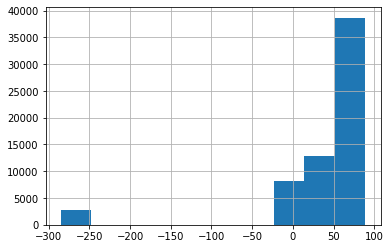

In [106]:
df['AGE'].hist()

In [107]:
df['LOS'] = df['DISCHTIME'].sub(df['ADMITTIME']) / np.timedelta64(1,'D') # subtract ADMITTIME from DISCHTIME and express difference in days 'D'

df['LOS']

0         4.164583
1        11.112500
2        13.895833
3         5.634722
4         5.585417
           ...    
62472     1.872917
62473     2.502083
62474     1.609722
62475     3.710417
62476     3.100000
Name: LOS, Length: 62477, dtype: float64

In [108]:
df['LOS'].describe()

count    62477.000000
mean        11.166875
std         14.141929
min         -0.945139
25%          3.866667
50%          6.888194
75%         12.938889
max        294.660417
Name: LOS, dtype: float64

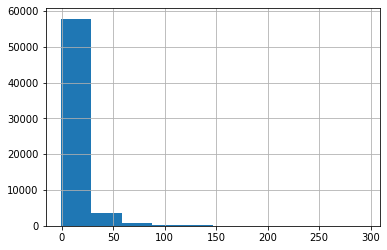

In [109]:
df['LOS'].hist()

In [111]:
df.loc[df['LOS'] <= 5, 'PREDLOS'] = 0 
df.loc[df['LOS'] > 5, 'PREDLOS'] = 1

In [112]:
for col_name in ['CALLOUT_COUNT', 'PRES_COUNT', 'PROC_COUNT', 'CPT_COUNT', 'LAB_COUNT', 'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT', 'OUTPUT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT']:
  df[col_name + '_DAY'] = df[col_name] / np.maximum(np.ceil(df['LOS']), 1)

In [113]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,IN_HOSP_DEATH,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,GENDER,DOB,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,SEPSIS,ORGAN_FAILURE,CARDIOVASCULAR,RENAL,HEPATIC,HEMATOLOGIC,METABOLIC,NEUROLOGIC,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,AGE,LOS,PREDLOS,CALLOUT_COUNT_DAY,PRES_COUNT_DAY,PROC_COUNT_DAY,CPT_COUNT_DAY,LAB_COUNT_DAY,INPUTS_CV_COUNT_DAY,INPUTS_MV_COUNT_DAY,OUTPUT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaT,0,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2078-11-11,1.3848,1.0,15,44.0,1.0,7.0,182.0,NaN,18.0,NaN,3,47.0,1,1,0,1,0,0,0,0,92.772727,142.111111,56.722222,76.000000,20.875000,36.851852,95.086957,133.750000,60,4.164583,0.0,0.200000,8.800000,0.200000,1.400000,36.4,NaN,3.6,NaN,0.600000,9.400000
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaT,0,MVA;TRAUMA,SINGLE,Government,None,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23,3.2653,NaN,9,NaN,9.0,NaN,408.0,331.0,NaN,89.0,3,27.0,0,1,0,0,0,0,0,0,108.268293,119.780488,53.317073,73.948718,18.291667,38.388888,99.288889,115.000000,18,11.112500,1.0,NaN,NaN,0.750000,NaN,34.0,27.583333,NaN,7.416667,0.250000,2.250000
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaT,0,INFECTED RIGHT FOOT,DIVORCED,Medicare,None,EPISCOPALIAN,WHITE,M,2096-08-27,3.2458,NaN,9,NaN,8.0,NaN,574.0,390.0,NaN,90.0,6,46.0,0,0,0,0,0,0,0,0,96.522727,109.454545,57.795455,73.727273,15.500000,36.697619,98.380952,149.619048,70,13.895833,1.0,NaN,NaN,0.571429,NaN,41.0,27.857143,NaN,6.428571,0.428571,3.285714
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaT,0,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,JEWISH,WHITE,M,1810-07-29,1.7603,1.0,15,30.0,2.0,8.0,207.0,NaN,21.0,20.0,4,NaN,0,1,0,1,0,0,1,0,50.038462,137.714286,44.571429,67.809524,17.038462,36.244444,97.346154,105.000000,-285,5.634722,1.0,0.166667,5.000000,0.333333,1.333333,34.5,NaN,3.5,3.333333,0.666667,NaN
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaT,0,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,JEWISH,WHITE,M,2055-03-16,5.5894,NaN,22,53.0,6.0,10.0,378.0,165.0,NaN,115.0,7,5.0,0,1,1,0,0,0,0,1,79.285714,130.814815,60.740741,79.740741,18.875000,37.074074,98.827586,141.300000,76,5.585417,1.0,NaN,8.833333,1.000000,1.666667,63.0,27.500000,NaN,19.166667,1.166667,0.833333


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 56 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SUBJECT_ID           62477 non-null  int64         
 1   HADM_ID              62477 non-null  int64         
 2   ADMISSION_TYPE       62477 non-null  object        
 3   ADMITTIME            62477 non-null  datetime64[ns]
 4   DISCHTIME            62477 non-null  datetime64[ns]
 5   DEATHTIME            6624 non-null   object        
 6   IN_HOSP_DEATH        62477 non-null  int64         
 7   DIAGNOSIS            62452 non-null  object        
 8   MARITAL_STATUS       52155 non-null  object        
 9   INSURANCE            62477 non-null  object        
 10  LANGUAGE             35933 non-null  object        
 11  RELIGION             61995 non-null  object        
 12  ETHNICITY            62477 non-null  object        
 13  GENDER               62477 non-

In [115]:
for col_name in ['CALLOUT_COUNT', 'PRES_COUNT', 'PROC_COUNT', 'CPT_COUNT', 'LAB_COUNT', 'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT', 'OUTPUT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT']:
  df[col_name] = df[col_name].fillna(0)
  df[col_name + '_DAY'] = df[col_name + '_DAY'].fillna(0)

In [116]:
df['DIAG_COUNT'] = df['DIAG_COUNT'].fillna(0)
df['LOS_ICU'] = df['LOS_ICU'].fillna(0)


In [117]:
df['HeartRate_Mean'] = df['HeartRate_Mean'].fillna(0)
df['SysBP_Mean'] = df['SysBP_Mean'].fillna(0)
df['DiasBP_Mean'] = df['DiasBP_Mean'].fillna(0)
df['MeanBP_Mean'] = df['MeanBP_Mean'].fillna(0)
df['RespRate_Mean'] = df['RespRate_Mean'].fillna(0)
df['TempC_Mean'] = df['TempC_Mean'].fillna(0)
df['SpO2_Mean'] = df['SpO2_Mean'].fillna(0)
df['Glucose_Mean'] = df['Glucose_Mean'].fillna(0)

In [118]:
df.isna().sum()

SUBJECT_ID                 0
HADM_ID                    0
ADMISSION_TYPE             0
ADMITTIME                  0
DISCHTIME                  0
DEATHTIME              55853
IN_HOSP_DEATH              0
DIAGNOSIS                 25
MARITAL_STATUS         10322
INSURANCE                  0
LANGUAGE               26544
RELIGION                 482
ETHNICITY                  0
GENDER                     0
DOB                        0
LOS_ICU                    0
CALLOUT_COUNT              0
DIAG_COUNT                 0
PRES_COUNT                 0
PROC_COUNT                 0
CPT_COUNT                  0
LAB_COUNT                  0
INPUTS_CV_COUNT            0
INPUTS_MV_COUNT            0
OUTPUT_COUNT               0
TRANSFER_COUNT             0
MICRO_COUNT                0
SEPSIS                     0
ORGAN_FAILURE              0
CARDIOVASCULAR             0
RENAL                      0
HEPATIC                    0
HEMATOLOGIC                0
METABOLIC                  0
NEUROLOGIC    

In [119]:
df.head()

,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,IN_HOSP_DEATH,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,GENDER,DOB,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,SEPSIS,ORGAN_FAILURE,CARDIOVASCULAR,RENAL,HEPATIC,HEMATOLOGIC,METABOLIC,NEUROLOGIC,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean,AGE,LOS,PREDLOS,CALLOUT_COUNT_DAY,PRES_COUNT_DAY,PROC_COUNT_DAY,CPT_COUNT_DAY,LAB_COUNT_DAY,INPUTS_CV_COUNT_DAY,INPUTS_MV_COUNT_DAY,OUTPUT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaT,0,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2078-11-11,1.3848,1.0,15,44.0,1.0,7.0,182.0,0.0,18.0,0.0,3,47.0,1,1,0,1,0,0,0,0,92.772727,142.111111,56.722222,76.000000,20.875000,36.851852,95.086957,133.750000,60,4.164583,0.0,0.200000,8.800000,0.200000,1.400000,36.4,0.000000,3.6,0.000000,0.600000,9.400000
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaT,0,MVA;TRAUMA,SINGLE,Government,None,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23,3.2653,0.0,9,0.0,9.0,0.0,408.0,331.0,0.0,89.0,3,27.0,0,1,0,0,0,0,0,0,108.268293,119.780488,53.317073,73.948718,18.291667,38.388888,99.288889,115.000000,18,11.112500,1.0,0.000000,0.000000,0.750000,0.000000,34.0,27.583333,0.0,7.416667,0.250000,2.250000
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaT,0,INFECTED RIGHT FOOT,DIVORCED,Medicare,None,EPISCOPALIAN,WHITE,M,2096-08-27,3.2458,0.0,9,0.0,8.0,0.0,574.0,390.0,0.0,90.0,6,46.0,0,0,0,0,0,0,0,0,96.522727,109.454545,57.795455,73.727273,15.500000,36.697619,98.380952,149.619048,70,13.895833,1.0,0.000000,0.000000,0.571429,0.000000,41.0,27.857143,0.0,6.428571,0.428571,3.285714
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaT,0,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,JEWISH,WHITE,M,1810-07-29,1.7603,1.0,15,30.0,2.0,8.0,207.0,0.0,21.0,20.0,4,0.0,0,1,0,1,0,0,1,0,50.038462,137.714286,44.571429,67.809524,17.038462,36.244444,97.346154,105.000000,-285,5.634722,1.0,0.166667,5.000000,0.333333,1.333333,34.5,0.000000,3.5,3.333333,0.666667,0.000000
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaT,0,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,JEWISH,WHITE,M,2055-03-16,5.5894,0.0,22,53.0,6.0,10.0,378.0,165.0,0.0,115.0,7,5.0,0,1,1,0,0,0,0,1,79.285714,130.814815,60.740741,79.740741,18.875000,37.074074,98.827586,141.300000,76,5.585417,1.0,0.000000,8.833333,1.000000,1.666667,63.0,27.500000,0.0,19.166667,1.166667,0.833333


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 56 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SUBJECT_ID           62477 non-null  int64         
 1   HADM_ID              62477 non-null  int64         
 2   ADMISSION_TYPE       62477 non-null  object        
 3   ADMITTIME            62477 non-null  datetime64[ns]
 4   DISCHTIME            62477 non-null  datetime64[ns]
 5   DEATHTIME            6624 non-null   object        
 6   IN_HOSP_DEATH        62477 non-null  int64         
 7   DIAGNOSIS            62452 non-null  object        
 8   MARITAL_STATUS       52155 non-null  object        
 9   INSURANCE            62477 non-null  object        
 10  LANGUAGE             35933 non-null  object        
 11  RELIGION             61995 non-null  object        
 12  ETHNICITY            62477 non-null  object        
 13  GENDER               62477 non-

In [121]:
df ['MARITAL_STATUS'].value_counts()
df['MARITAL_STATUS'].value_counts(dropna = False) 
# by specifying dropna = False, the function counts the number of NaN too
df['MARITAL_STATUS'] = df['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)')
df['MARITAL_STATUS'].value_counts(dropna = False) # no more NaN's!

MARRIED              25939
SINGLE               14105
UNKNOWN (DEFAULT)    10694
WIDOWED               7659
DIVORCED              3455
SEPARATED              609
LIFE PARTNER            16
Name: MARITAL_STATUS, dtype: int64

In [123]:
df['RELIGION'].value_counts(dropna = False)
df['RELIGION'] = df['RELIGION'].fillna('NOT SPECIFIED')
df['RELIGION'].value_counts(dropna = False) # no more NaN's!

CATHOLIC                  21956
NOT SPECIFIED             12857
UNOBTAINABLE               8573
PROTESTANT QUAKER          7661
JEWISH                     5656
OTHER                      2862
EPISCOPALIAN                816
GREEK ORTHODOX              482
CHRISTIAN SCIENTIST         453
BUDDHIST                    289
MUSLIM                      244
JEHOVAH'S WITNESS           146
UNITARIAN-UNIVERSALIST      132
HINDU                       116
ROMANIAN EAST. ORTH          93
7TH DAY ADVENTIST            86
BAPTIST                      28
HEBREW                       18
METHODIST                     8
LUTHERAN                      1
Name: RELIGION, dtype: int64

In [124]:
df['LANGUAGE'].value_counts(dropna = False)
df['LANGUAGE'] = df['LANGUAGE'].fillna('ENGL')
df['LANGUAGE'].value_counts(dropna = False) # no more NaN's!

ENGL    57604
SPAN     1151
RUSS      848
PTUN      675
CANT      439
        ...  
*RUS        1
*FIL        1
*PUN        1
*FAR        1
*ARA        1
Name: LANGUAGE, Length: 75, dtype: int64

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 56 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   SUBJECT_ID           62477 non-null  int64         
 1   HADM_ID              62477 non-null  int64         
 2   ADMISSION_TYPE       62477 non-null  object        
 3   ADMITTIME            62477 non-null  datetime64[ns]
 4   DISCHTIME            62477 non-null  datetime64[ns]
 5   DEATHTIME            6624 non-null   object        
 6   IN_HOSP_DEATH        62477 non-null  int64         
 7   DIAGNOSIS            62452 non-null  object        
 8   MARITAL_STATUS       62477 non-null  object        
 9   INSURANCE            62477 non-null  object        
 10  LANGUAGE             62477 non-null  object        
 11  RELIGION             62477 non-null  object        
 12  ETHNICITY            62477 non-null  object        
 13  GENDER               62477 non-

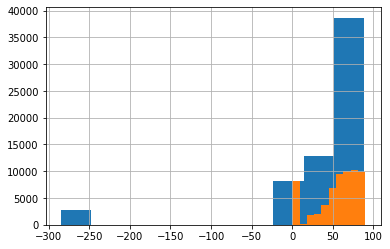

In [126]:
df['AGE'].hist()
df.loc[df['AGE'] < 0, 'AGE'] = 90
df['AGE'].hist()

In [127]:
tmp_df_admissions = pd.get_dummies(df['ADMISSION_TYPE'], prefix = 'ADMISSION_TYPE')
tmp_df_admissions

,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT
0,0,1,0,0
1,0,1,0,0
2,0,1,0,0
3,0,1,0,0
4,0,1,0,0
...,...,...,...,...
62472,0,1,0,0
62473,0,1,0,0
62474,0,1,0,0
62475,0,1,0,0


In [128]:
df = pd.concat([df, tmp_df_admissions], axis = 1) 
# add the above temporary dataframe to the original dataframe, axis = 1 specifies that we want to stack them horizontally not vertically

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 60 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   SUBJECT_ID                62477 non-null  int64         
 1   HADM_ID                   62477 non-null  int64         
 2   ADMISSION_TYPE            62477 non-null  object        
 3   ADMITTIME                 62477 non-null  datetime64[ns]
 4   DISCHTIME                 62477 non-null  datetime64[ns]
 5   DEATHTIME                 6624 non-null   object        
 6   IN_HOSP_DEATH             62477 non-null  int64         
 7   DIAGNOSIS                 62452 non-null  object        
 8   MARITAL_STATUS            62477 non-null  object        
 9   INSURANCE                 62477 non-null  object        
 10  LANGUAGE                  62477 non-null  object        
 11  RELIGION                  62477 non-null  object        
 12  ETHNICITY         

In [130]:
df['GENDER'].value_counts()
df['GENDER_F'] = (df['GENDER'] == 'F') * 1
df['GENDER_F'].value_counts()

0    34986
1    27491
Name: GENDER_F, dtype: int64

In [131]:
df['RELIGION'].value_counts()

CATHOLIC                  21956
NOT SPECIFIED             12857
UNOBTAINABLE               8573
PROTESTANT QUAKER          7661
JEWISH                     5656
OTHER                      2862
EPISCOPALIAN                816
GREEK ORTHODOX              482
CHRISTIAN SCIENTIST         453
BUDDHIST                    289
MUSLIM                      244
JEHOVAH'S WITNESS           146
UNITARIAN-UNIVERSALIST      132
HINDU                       116
ROMANIAN EAST. ORTH          93
7TH DAY ADVENTIST            86
BAPTIST                      28
HEBREW                       18
METHODIST                     8
LUTHERAN                      1
Name: RELIGION, dtype: int64

In [132]:
tmp_categories = list(df['RELIGION'].value_counts()[:3].keys()) + ['OTHERS'] # retain the top 3 categories, plus 'OTHERS

tmp_categories_dtype = pd.CategoricalDtype(tmp_categories)

tmp_df = df['RELIGION'].astype(tmp_categories_dtype).fillna('OTHERS') 
tmp_df = pd.get_dummies(tmp_df, prefix = 'RELIGION') # create a temporary dataframe with the modified categories

df = pd.concat([df, tmp_df], axis = 1) # add to original dataframe

tmp_df

,RELIGION_CATHOLIC,RELIGION_NOT SPECIFIED,RELIGION_UNOBTAINABLE,RELIGION_OTHERS
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,0,0,0,1
4,0,0,0,1
...,...,...,...,...
62472,0,0,1,0
62473,0,0,0,1
62474,0,1,0,0
62475,0,1,0,0


In [133]:
tmp_categories = list(df['INSURANCE'].value_counts()[:3].keys()) + ['OTHERS'] # retain the top 3 categories, plus 'OTHERS

tmp_categories_dtype = pd.CategoricalDtype(tmp_categories)

tmp_df = df['INSURANCE'].astype(tmp_categories_dtype).fillna('OTHERS')
tmp_df = pd.get_dummies(tmp_df, prefix = 'INSURANCE') # create a temporary dataframe with the modified categories

df = pd.concat([df, tmp_df], axis = 1) # add to original dataframe

tmp_df

,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Medicaid,INSURANCE_OTHERS
0,1,0,0,0
1,0,0,0,1
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
62472,0,1,0,0
62473,0,0,1,0
62474,0,1,0,0
62475,1,0,0,0


In [134]:
tmp_categories = list(df['MARITAL_STATUS'].value_counts()[:3].keys()) + ['OTHERS'] # retain the top 3 categories, plus 'OTHERS

tmp_categories_dtype = pd.CategoricalDtype(tmp_categories)

tmp_df = df['MARITAL_STATUS'].astype(tmp_categories_dtype).fillna('OTHERS')
tmp_df = pd.get_dummies(tmp_df, prefix = 'MARITAL_STATUS') # create a temporary dataframe with the modified categories

df = pd.concat([df, tmp_df], axis = 1) # add to original dataframe

tmp_df

,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS
0,0,0,0,1
1,0,1,0,0
2,0,0,0,1
3,1,0,0,0
4,0,0,0,1
...,...,...,...,...
62472,0,0,1,0
62473,0,0,0,1
62474,1,0,0,0
62475,0,0,0,1


In [135]:
tmp_categories = list(df['LANGUAGE'].value_counts()[:3].keys()) + ['OTHERS'] # retain the top 3 categories, plus 'OTHERS

tmp_categories_dtype = pd.CategoricalDtype(tmp_categories)

tmp_df = df['LANGUAGE'].astype(tmp_categories_dtype).fillna('OTHERS')
tmp_df = pd.get_dummies(tmp_df, prefix = 'LANGUAGE') # create a temporary dataframe with the modified categories

df = pd.concat([df, tmp_df], axis = 1) # add to original dataframe

tmp_df

,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
62472,0,0,0,1
62473,0,0,0,1
62474,0,0,0,1
62475,1,0,0,0


In [136]:
tmp_categories = list(df['ETHNICITY'].value_counts()[:3].keys()) + ['OTHERS'] # retain the top 3 categories, plus 'OTHERS

tmp_categories_dtype = pd.CategoricalDtype(tmp_categories)

tmp_df = df['ETHNICITY'].astype(tmp_categories_dtype).fillna('OTHERS')
tmp_df = pd.get_dummies(tmp_df, prefix = 'ETHNICITY') # create a temporary dataframe with the modified categories

df = pd.concat([df, tmp_df], axis = 1) # add to original dataframe

tmp_df

,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,1,0,0,0
1,0,1,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
62472,0,0,1,0
62473,0,0,0,1
62474,1,0,0,0
62475,0,0,1,0


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62477 entries, 0 to 62476
Data columns (total 81 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   SUBJECT_ID                        62477 non-null  int64         
 1   HADM_ID                           62477 non-null  int64         
 2   ADMISSION_TYPE                    62477 non-null  object        
 3   ADMITTIME                         62477 non-null  datetime64[ns]
 4   DISCHTIME                         62477 non-null  datetime64[ns]
 5   DEATHTIME                         6624 non-null   object        
 6   IN_HOSP_DEATH                     62477 non-null  int64         
 7   DIAGNOSIS                         62452 non-null  object        
 8   MARITAL_STATUS                    62477 non-null  object        
 9   INSURANCE                         62477 non-null  object        
 10  LANGUAGE                          62477 non-nu

In [138]:
# Grant access to your Google Drive. You would need to authenicate once again
from google.colab import drive 
drive.mount('/content/gdrive', force_remount = True)

gdrive_rootpath = '/content/gdrive/MyDrive/'

Mounted at /content/gdrive


In [139]:
df.to_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv', index = False)

In [140]:
pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')

# if you want to save it as a variable, run this instead
# df = pd.read_csv(gdrive_rootpath + 'mimic_in_hosp_death_clean.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SUBJECT_ID,HADM_ID,ADMISSION_TYPE,ADMITTIME,DISCHTIME,DEATHTIME,IN_HOSP_DEATH,DIAGNOSIS,MARITAL_STATUS,INSURANCE,LANGUAGE,RELIGION,ETHNICITY,GENDER,DOB,LOS_ICU,CALLOUT_COUNT,DIAG_COUNT,PRES_COUNT,PROC_COUNT,CPT_COUNT,LAB_COUNT,INPUTS_CV_COUNT,INPUTS_MV_COUNT,OUTPUT_COUNT,TRANSFER_COUNT,MICRO_COUNT,SEPSIS,ORGAN_FAILURE,CARDIOVASCULAR,RENAL,HEPATIC,HEMATOLOGIC,METABOLIC,NEUROLOGIC,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,...,SpO2_Mean,Glucose_Mean,AGE,LOS,PREDLOS,CALLOUT_COUNT_DAY,PRES_COUNT_DAY,PROC_COUNT_DAY,CPT_COUNT_DAY,LAB_COUNT_DAY,INPUTS_CV_COUNT_DAY,INPUTS_MV_COUNT_DAY,OUTPUT_COUNT_DAY,TRANSFER_COUNT_DAY,MICRO_COUNT_DAY,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,GENDER_F,RELIGION_CATHOLIC,RELIGION_NOT SPECIFIED,RELIGION_UNOBTAINABLE,RELIGION_OTHERS,INSURANCE_Medicare,INSURANCE_Private,INSURANCE_Medicaid,INSURANCE_OTHERS,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_OTHERS,LANGUAGE_ENGL,LANGUAGE_SPAN,LANGUAGE_RUSS,LANGUAGE_OTHERS,ETHNICITY_WHITE,ETHNICITY_BLACK/AFRICAN AMERICAN,ETHNICITY_UNKNOWN/NOT SPECIFIED,ETHNICITY_OTHERS
0,7275,136809,EMERGENCY,2139-08-28 12:35:00,2139-09-01 16:32:00,NaN,0,ALTERED MENTAL STATUS; DYSPNEA,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2078-11-11 00:00:00,1.3848,1.0,15,44.0,1.0,7.0,182.0,0.0,18.0,0.0,3,47.0,1,1,0,1,0,0,0,0,92.772727,142.111111,56.722222,76.000000,20.875000,...,95.086957,133.750000,60,4.164583,0.0,0.200000,8.800000,0.200000,1.400000,36.400000,0.000000,3.600000,0.000000,0.600000,9.400000,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
1,17575,187131,EMERGENCY,2124-10-21 08:32:00,2124-11-01 11:14:00,NaN,0,MVA;TRAUMA,SINGLE,Government,ENGL,OTHER,BLACK/AFRICAN AMERICAN,M,2106-01-23 00:00:00,3.2653,0.0,9,0.0,9.0,0.0,408.0,331.0,0.0,89.0,3,27.0,0,1,0,0,0,0,0,0,108.268293,119.780488,53.317073,73.948718,18.291667,...,99.288889,115.000000,18,11.112500,1.0,0.000000,0.000000,0.750000,0.000000,34.000000,27.583333,0.000000,7.416667,0.250000,2.250000,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0
2,25251,142346,EMERGENCY,2167-01-23 16:23:00,2167-02-06 13:53:00,NaN,0,INFECTED RIGHT FOOT,DIVORCED,Medicare,ENGL,EPISCOPALIAN,WHITE,M,2096-08-27 00:00:00,3.2458,0.0,9,0.0,8.0,0.0,574.0,390.0,0.0,90.0,6,46.0,0,0,0,0,0,0,0,0,96.522727,109.454545,57.795455,73.727273,15.500000,...,98.380952,149.619048,70,13.895833,1.0,0.000000,0.000000,0.571429,0.000000,41.000000,27.857143,0.000000,6.428571,0.428571,3.285714,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
3,32339,181355,EMERGENCY,2110-07-29 23:56:00,2110-08-04 15:10:00,NaN,0,GASTROINTESTINAL BLEED;CHEST PAIN;TELEMETRY,MARRIED,Medicare,ENGL,JEWISH,WHITE,M,1810-07-29 00:00:00,1.7603,1.0,15,30.0,2.0,8.0,207.0,0.0,21.0,20.0,4,0.0,0,1,0,1,0,0,1,0,50.038462,137.714286,44.571429,67.809524,17.038462,...,97.346154,105.000000,90,5.634722,1.0,0.166667,5.000000,0.333333,1.333333,34.500000,0.000000,3.500000,3.333333,0.666667,0.000000,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,30746,155603,EMERGENCY,2131-08-22 23:07:00,2131-08-28 13:10:00,NaN,0,ALTERED MENTAL STATUS,DIVORCED,Medicare,ENGL,JEWISH,WHITE,M,2055-03-16 00:00:00,5.5894,0.0,22,53.0,6.0,10.0,378.0,165.0,0.0,115.0,7,5.0,0,1,1,0,0,0,0,1,79.285714,130.814815,60.740741,79.740741,18.875000,...,98.827586,141.300000,76,5.585417,1.0,0.000000,8.833333,1.000000,1.666667,63.000000,27.500000,0.000000,19.166667,1.166667,0.833333,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62472,31355,146717,EMERGENCY,2110-07-28 22:03:00,2110-07-30 19:00:00,NaN,0,NECROTIZING PANCREATITIS,UNKNOWN (DEFAULT),Private,PTUN,UNOBTAINABLE,UNKNOWN/NOT SPECIFIED,M,2071-09-27 00:00

```
# This is formatted as code
```

## Exploratory data analysis

In [141]:
df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMISSION_TYPE', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'IN_HOSP_DEATH', 'DIAGNOSIS', 'MARITAL_STATUS',
       'INSURANCE', 'LANGUAGE', 'RELIGION', 'ETHNICITY', 'GENDER', 'DOB',
       'LOS_ICU', 'CALLOUT_COUNT', 'DIAG_COUNT', 'PRES_COUNT', 'PROC_COUNT',
       'CPT_COUNT', 'LAB_COUNT', 'INPUTS_CV_COUNT', 'INPUTS_MV_COUNT',
       'OUTPUT_COUNT', 'TRANSFER_COUNT', 'MICRO_COUNT', 'SEPSIS',
       'ORGAN_FAILURE', 'CARDIOVASCULAR', 'RENAL', 'HEPATIC', 'HEMATOLOGIC',
       'METABOLIC', 'NEUROLOGIC', 'HeartRate_Mean', 'SysBP_Mean',
       'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean',
       'SpO2_Mean', 'Glucose_Mean', 'AGE', 'LOS', 'PREDLOS',
       'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY', 'PROC_COUNT_DAY',
       'CPT_COUNT_DAY', 'LAB_COUNT_DAY', 'INPUTS_CV_COUNT_DAY',
       'INPUTS_MV_COUNT_DAY', 'OUTPUT_COUNT_DAY', 'TRANSFER_COUNT_DAY',
       'MICRO_COUNT_DAY', 'ADMISSION_TYPE_ELECTIVE',
       'ADMISSION_TYPE_EMERGENCY', 'ADMISSI

In [66]:
df['IN_HOSP_DEATH'].value_counts()

0    55853
1     6624
Name: IN_HOSP_DEATH, dtype: int64

In [67]:
# visualization package
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
df[['GENDER', 'IN_HOSP_DEATH']].groupby(['GENDER']).mean()

,IN_HOSP_DEATH
GENDER,
F,0.109199
M,0.103527


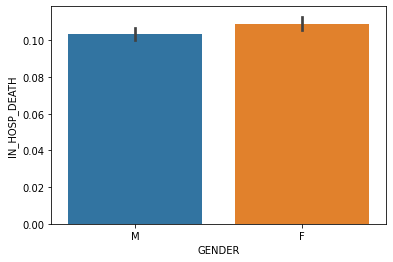

In [69]:
sns.barplot(x = 'GENDER', y = 'IN_HOSP_DEATH', data = df)

In [70]:
df[['ADMISSION_TYPE', 'IN_HOSP_DEATH']].groupby(['ADMISSION_TYPE']).mean()

,IN_HOSP_DEATH
ADMISSION_TYPE,
ELECTIVE,0.031416
EMERGENCY,0.135993
NEWBORN,0.007829
URGENT,0.127615


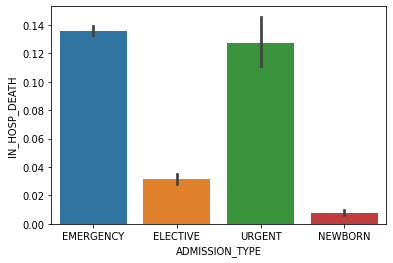

In [71]:
sns.barplot(x = 'ADMISSION_TYPE', y = 'IN_HOSP_DEATH', data = df)

In [72]:
df[['MARITAL_STATUS', 'IN_HOSP_DEATH']].groupby(['MARITAL_STATUS']).mean()

,IN_HOSP_DEATH
MARITAL_STATUS,
DIVORCED,0.107959
LIFE PARTNER,0.000000
MARRIED,0.115772
SEPARATED,0.101806
SINGLE,0.088621
UNKNOWN (DEFAULT),0.071629
WIDOWED,0.152761


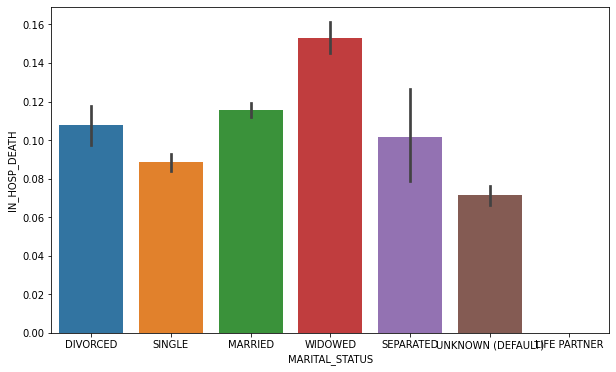

In [73]:
plt.figure(figsize = (10, 6)) # adjust the size of your plots, formatted as (width, height)
sns.barplot(x = 'MARITAL_STATUS', y = 'IN_HOSP_DEATH', data = df)

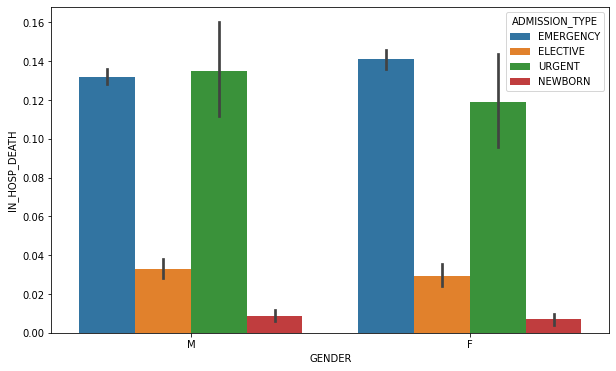

In [74]:
plt.figure(figsize = (10, 6))
sns.barplot(x = 'GENDER', y = 'IN_HOSP_DEATH', hue = 'ADMISSION_TYPE', data = df)

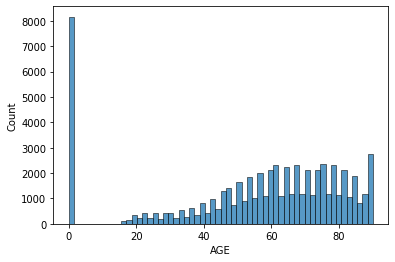

In [75]:
sns.histplot(x = 'AGE', data = df)

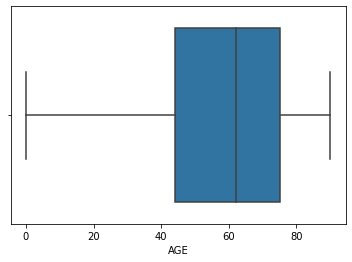

In [76]:
sns.boxplot(x = 'AGE', data = df)


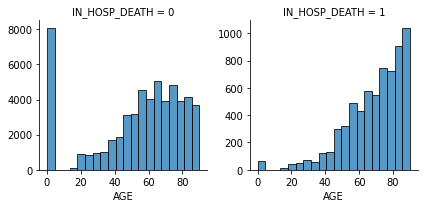

In [77]:
g = sns.FacetGrid(df, col = 'IN_HOSP_DEATH', sharey = False)
g.map(sns.histplot, 'AGE', bins = 20)

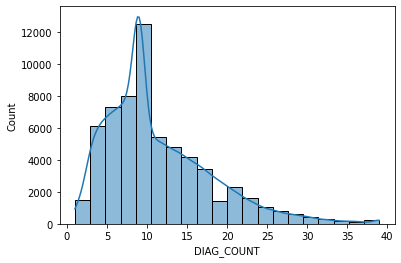

In [78]:
sns.histplot(x = 'DIAG_COUNT', data = df, bins = 20, kde = True) # kde = True adds a smoothed line

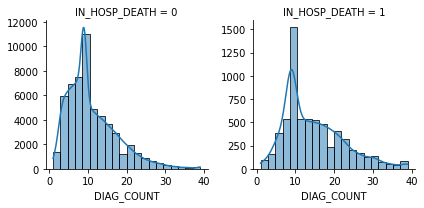

In [79]:
g = sns.FacetGrid(df, col = 'IN_HOSP_DEATH', sharey = False)
g.map(sns.histplot, 'DIAG_COUNT', bins = 20, kde = True)

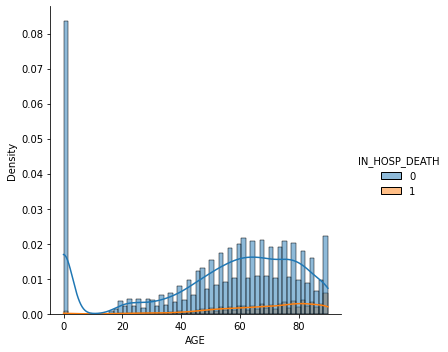

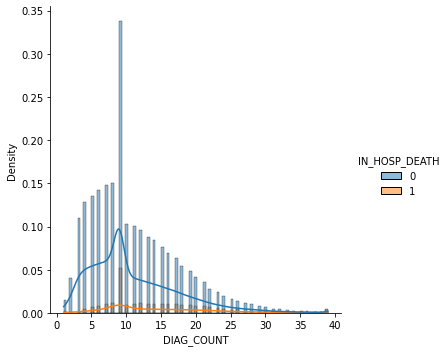

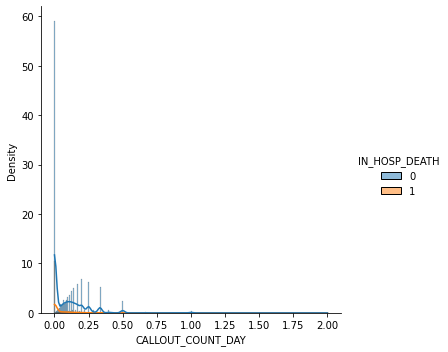

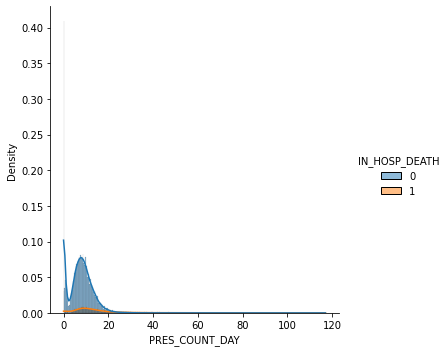

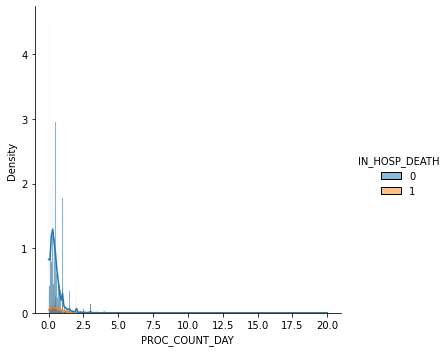

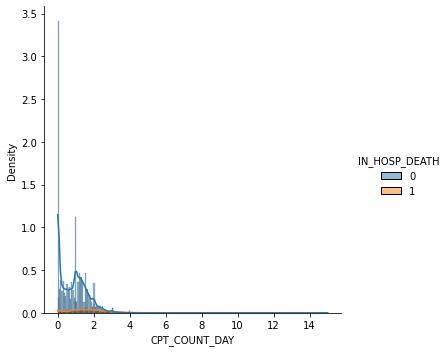

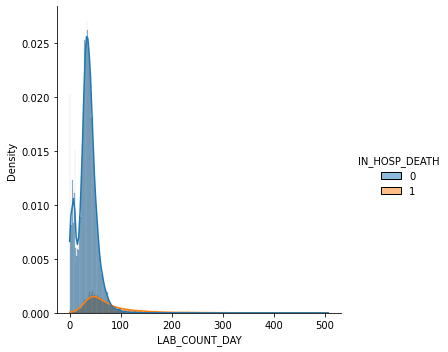

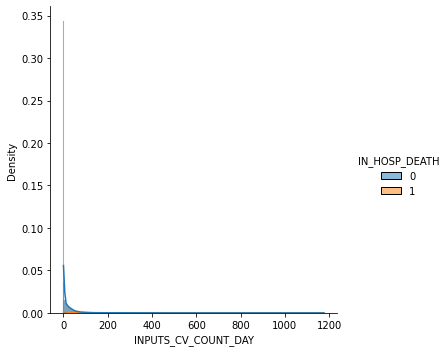

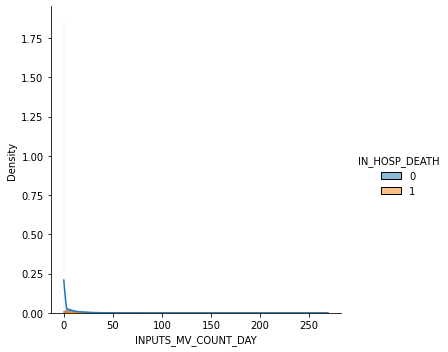

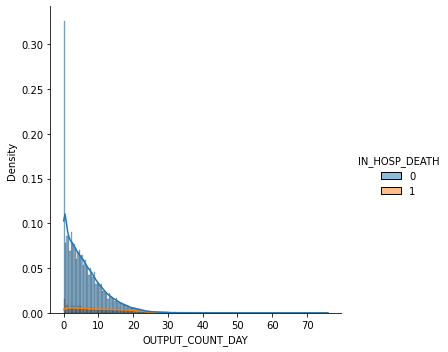

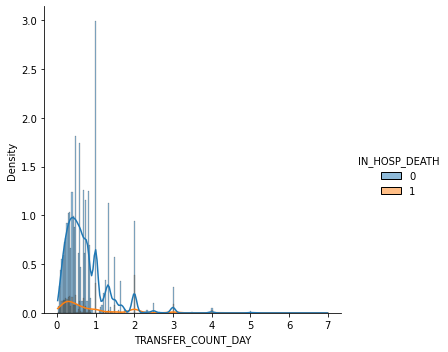

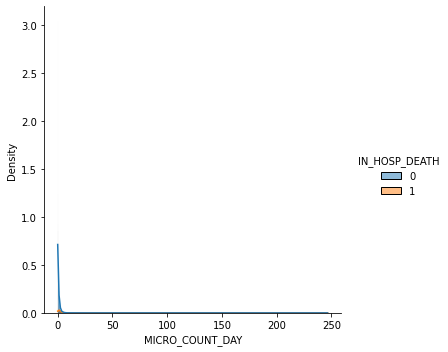

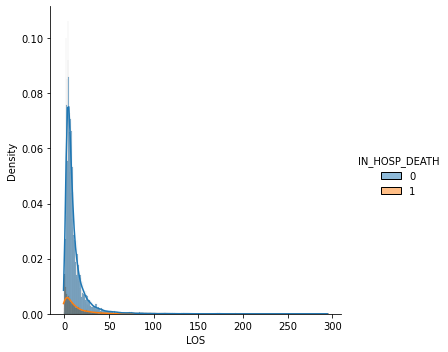

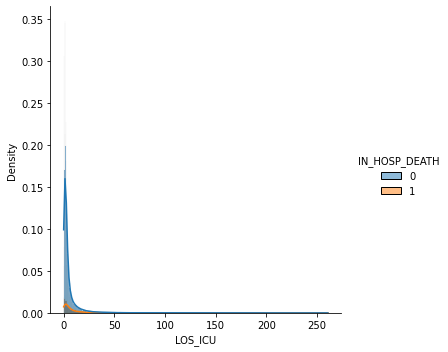

In [80]:
numerical_feaures = ['AGE', 'DIAG_COUNT', 'CALLOUT_COUNT_DAY', 'PRES_COUNT_DAY', 
                     'PROC_COUNT_DAY', 'CPT_COUNT_DAY', 'LAB_COUNT_DAY',
                     'INPUTS_CV_COUNT_DAY', 'INPUTS_MV_COUNT_DAY', 'OUTPUT_COUNT_DAY', 
                     'TRANSFER_COUNT_DAY', 'MICRO_COUNT_DAY', 'LOS', 'LOS_ICU']

for col_name in numerical_feaures:
  sns.displot(data = df, x = col_name, hue = 'IN_HOSP_DEATH', stat = 'density', kde = True)
  plt.show()